In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
ticker = yf.Ticker("INFY")
data=ticker.history(start="2022-01-01",end="2024-12-31",interval="1d")
data = data.dropna()
data=data.drop(['Dividends','Stock Splits'],axis=1)

print(data.head(30))

                                Open       High        Low      Close  \
Date                                                                    
2022-01-03 00:00:00-05:00  23.443218  23.581718  23.221621  23.323187   
2022-01-04 00:00:00-05:00  23.313952  23.424751  23.064653  23.184687   
2022-01-05 00:00:00-05:00  22.935385  23.009251  22.390623  22.436789   
2022-01-06 00:00:00-05:00  22.344461  22.612225  22.132095  22.261362   
2022-01-07 00:00:00-05:00  22.362927  22.501427  22.132095  22.344461   
2022-01-10 00:00:00-05:00  22.769192  22.879992  22.556827  22.870758   
2022-01-11 00:00:00-05:00  22.972321  23.138519  22.769190  23.101587   
2022-01-12 00:00:00-05:00  24.144945  24.366543  23.554018  23.775616   
2022-01-13 00:00:00-05:00  23.766380  23.803314  23.517082  23.637115   
2022-01-14 00:00:00-05:00  23.747913  24.274210  23.618648  24.191111   
2022-01-18 00:00:00-05:00  23.738680  23.794081  23.470917  23.554016   
2022-01-19 00:00:00-05:00  23.064653  23.129286  22

In [2]:
# MACD
def calculate_macd(data, price_col):
    short_period = 12
    long_period = 26
    signal_line_period = 9
    ema_short = data[price_col].ewm(span=short_period, adjust=False).mean()
    ema_long = data[price_col].ewm(span=long_period, adjust=False).mean()
    data['MACD'] = ema_short - ema_long
    data['Signal_MACD'] = data['MACD'].ewm(span=signal_line_period, adjust=False).mean()
    data['Signals_from_MACD'] = 0
    data.loc[data['MACD'] > data['Signal_MACD'], 'Signals_from_MACD'] = 1
    data.loc[data['MACD'] < data['Signal_MACD'], 'Signals_from_MACD'] = -1
    return data

# RSI
def calculate_rsi(data, price_col, period=14):
    delta = data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data['Signals_from_RSI'] = 0
    data.loc[data['RSI'] < 30, 'Signals_from_RSI'] = 1
    data.loc[data['RSI'] > 70, 'Signals_from_RSI'] = -1
    return data

In [19]:
def generate_signals(data):
    macd_weight = 0.6
    rsi_weight = 0.4
    data["weighted_signal"] = macd_weight * data["Signals_from_MACD"] + rsi_weight * data["Signals_from_RSI"]
    data["signal"] = 0
    data["signal"] = np.where(data["weighted_signal"] > 0.5, 1, data["signal"])
    data["signal"] = np.where(data["weighted_signal"] < -0.5, -1, data["signal"])
    return data

In [20]:
def run_strategy(data, price_column, initial_capital=1000):
    position = 0
    capital = initial_capital
    stop_loss_percent = 5
    take_profit_percent = 10
    no_of_stocks = 0
    returns = []
    long_short_trades = []

    portfolio_values = []   # <-- Track portfolio value over time

    start_trade = 0
    long_trade_count = 0
    short_trade_count = 0

    for i in range(len(data)):
        price = data[price_column].iloc[i]
        signal = data['signal'].iloc[i]
        current_position = position

        # Update portfolio value based on position
        if position == 0:
            portfolio_value = capital
        elif position == 1:
            portfolio_value = capital + no_of_stocks * (price - entry_price)
        elif position == -1:
            # Short position: capital + profit from price decrease
            portfolio_value = capital + no_of_stocks * (entry_price - price)

        portfolio_values.append(portfolio_value)

        # Entry logic
        if position == 0:
            if signal == 1:
                entry_price = price
                no_of_stocks = capital / entry_price
                position = 1
                long_trade_count += 1
            elif signal == -1:
                entry_price = price
                no_of_stocks = capital / entry_price
                position = -1
                short_trade_count += 1

        # Exit logic
        elif position == 1:
            if price >= entry_price * (1 + take_profit_percent / 100) or price <= entry_price * (1 - stop_loss_percent / 100) or signal == -1:
                ret = (price - entry_price) / entry_price
                capital += no_of_stocks * (price - entry_price)
                returns.append(ret)
                position = 0

        elif position == -1:
            if price <= entry_price * (1 - stop_loss_percent / 100) or price >= entry_price * (1 + take_profit_percent / 100) or signal == 1:
                ret = (entry_price - price) / entry_price
                capital += no_of_stocks * (entry_price - price)
                returns.append(ret)
                position = 0

        if current_position != position:
            long_short_trades.append(position)
            end_trade = i
            start_trade = i


    # Close any open positions at the end
    if position != 0:
        final_price = data[price_column].iloc[-1]
        if position == 1:
            ret = (final_price - entry_price) / entry_price
            capital += no_of_stocks * (final_price - entry_price)
        elif position == -1:
            ret = (entry_price - final_price) / entry_price
            capital += no_of_stocks * (entry_price - final_price)
        returns.append(ret)
        portfolio_values.append(capital)  # Append final portfolio value

    returns_array = np.array(returns)
    net_capital = capital
    total_return_percent = ((net_capital - initial_capital) / initial_capital) * 100
    total_trades = long_trade_count + short_trade_count
    win_rate = np.sum(returns_array > 0) / len(returns_array) * 100 if len(returns_array) > 0 else 0
    drawdowns = np.minimum(returns_array, 0)
    avg_drawdown = np.mean(drawdowns) * 100 if len(drawdowns) > 0 else 0
    max_drawdown = np.min(drawdowns) * 100 if len(drawdowns) > 0 else 0
    mean_return = np.mean(returns_array)
    std_return = np.std(returns_array)
    sharpe_ratio = (mean_return / std_return) * np.sqrt(252) if std_return != 0 else 0
    negative_returns = returns_array[returns_array < 0]
    downside_std = np.std(negative_returns)
    sortino_ratio = (mean_return / downside_std) * np.sqrt(252) if downside_std != 0 else 0


    return {
        "Return %": total_return_percent,
        "Net Capital": net_capital,
        "Total Trades": total_trades,
        "Win Rate %": win_rate,
        "Total Long Trades": long_trade_count,
        "Total Short Trades": short_trade_count,
        "Avg Drawdown %": avg_drawdown,
        "Max Drawdown %": max_drawdown,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Portfolio Values": portfolio_values  # <-- Return portfolio values
    }


In [21]:

data = calculate_macd(data, 'Close')
data = calculate_rsi(data, 'Close')
data = generate_signals(data)
metrics = run_strategy(data, price_column='Close')
portfolio = metrics["Portfolio Values"]

In [22]:
metric_data=pd.DataFrame({"Metrics": metrics})
print(metric_data)


                                                              Metrics
Return %                                                     9.917938
Net Capital                                               1099.179384
Total Trades                                                       60
Win Rate %                                                  46.666667
Total Long Trades                                                  30
Total Short Trades                                                 30
Avg Drawdown %                                              -2.063929
Max Drawdown %                                             -10.576924
Sharpe Ratio                                                 0.887466
Sortino Ratio                                                1.837574
Portfolio Values    [1000, 1000, 1032.2582794734183, 1039.82476013...


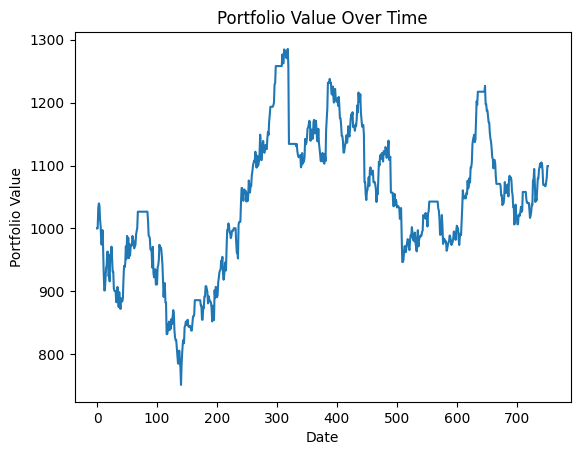

In [25]:
plt.plot(portfolio)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.show()
